# Throughput Benchmark Plotter (SPS vs Num Envs)

Load one or more JSON result files from `benchmarks/results/` or elsewhere and plot Steps Per Second (SPS) vs number of environments.

In [14]:
# Imports
import json
import os
from collections import defaultdict
from pathlib import Path
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import EngFormatter, ScalarFormatter, FuncFormatter
from pyprojroot import here

# Configure default directory to look for results
DEFAULT_RESULTS_DIR = here('benchmarks/results')

In [15]:
def load_json(p: Path) -> dict[str, Any]:
    with p.open('r') as f:
        return json.load(f)


def load_results(paths: list[Path]) -> list[dict[str, Any]]:
    return [load_json(p) for p in paths]


def guess_result_files(dir_path: Path = DEFAULT_RESULTS_DIR) -> list[Path]:
    if not dir_path.exists():
        return []
    return sorted(dir_path.glob('*.json'))


def normalize_records(run: dict[str, Any], source: Path) -> list[dict[str, Any]]:
    """Flatten a run JSON into per-(mode,num_envs) records.

    Supports the new format: {meta: {..., mode, run_tag, timestamp, async_chunk_size?}, throughput: { num_envs: { mode: { sps, times, ... } } }}
    Also tolerates the older combined format by checking common keys.
    """
    meta = run.get('meta', {})
    run_tag = meta.get('run_tag', '')
    ts = meta.get('timestamp', '')
    system = meta.get('system', {})
    mode_in_meta = meta.get('mode')  # new per-mode files

    records: list[dict[str, Any]] = []
    thr = run.get('throughput', {})

    # New format: { num_envs: { '<mode>': { ... } } }
    if isinstance(thr, dict) and thr and any(isinstance(v, dict) and any(k2 in v for k2 in ('arcle-sync','arcle-async','jaxarc-jit','jaxarc-pmap')) for v in thr.values()):
        for num_envs_str, per_mode in thr.items():
            try:
                num_envs = int(num_envs_str)
            except Exception:
                num_envs = num_envs_str
            for mode_name, payload in per_mode.items():
                sps = payload.get('sps', []) or []
                times = payload.get('times', []) or []
                records.append({
                    'num_envs': num_envs,
                    'mode': mode_name,
                    'sps': sps,
                    'times': times,
                    'run_tag': run_tag,
                    'timestamp': ts,
                    'system': system,
                    'source': str(source),
                })
        return records

    # Legacy fallback: try to detect flat keys 'JaxARC'/'ARCLE'
    if isinstance(thr, dict):
        for num_envs_str, payload in thr.items():
            try:
                num_envs = int(num_envs_str)
            except Exception:
                num_envs = num_envs_str
            # Two buckets in old format
            for mode_name in ('JaxARC', 'ARCLE'):
                if mode_name in payload:
                    item = payload[mode_name]
                    records.append({
                        'num_envs': num_envs,
                        'mode': mode_name,
                        'sps': item.get('sps', []) or [],
                        'times': item.get('times', []) or [],
                        'run_tag': run_tag,
                        'timestamp': ts,
                        'system': system,
                        'source': str(source),
                    })
    # If meta has a single mode, attach it
    if mode_in_meta and not any(r.get('mode') for r in records):
        for r in records:
            r['mode'] = mode_in_meta
    return records


# Example: auto-discover JSONs; you can override by providing explicit paths in the next cell.
auto_files = guess_result_files()
auto_files

[PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arcle_vs_jaxarc_cpu_arcle-sync_20250911-174928.json'),
 PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arcle_vs_jaxarc_cpu_jaxarc-jit_20250913-110915.json')]

In [16]:
# Manually specify files if desired, else use auto_files
files = auto_files  # e.g., [Path('benchmarks/results/arcle_vs_jaxarc_cpu_arcle-sync_20250911-173456.json')]
files

[PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arcle_vs_jaxarc_cpu_arcle-sync_20250911-174928.json'),
 PosixPath('/Users/aadam/workspace/JaxARC/benchmarks/results/arcle_vs_jaxarc_cpu_jaxarc-jit_20250913-110915.json')]

In [17]:
# Load and normalize data for plotting
runs = [load_json(p) for p in files]
records = []
for p, run in zip(files, runs):
    records.extend(normalize_records(run, p))
len(records)

34

In [18]:
# Build filtering and aggregation utilities
from dataclasses import dataclass

@dataclass
class Filters:
    run_tag_contains: list[str]
    modes: list[str]


def filter_records(records: list[dict[str, Any]], flt: Filters) -> list[dict[str, Any]]:
    def ok(r: dict[str, Any]) -> bool:
        tag = (r.get('run_tag') or '').lower()
        if flt.run_tag_contains:
            if not any(s.lower() in tag for s in flt.run_tag_contains):
                return False
        if flt.modes:
            if r.get('mode') not in flt.modes:
                return False
        return True
    return [r for r in records if ok(r)]


def aggregate(records: list[dict[str, Any]]):
    # Group by (mode, run_tag, num_envs) and compute mean/std over SPS lists
    grouped: dict[tuple, list[float]] = defaultdict(list)
    for r in records:
        key = (r.get('mode'), r.get('run_tag'), r.get('num_envs'))
        # Each record's sps is a list across repeats; extend into the group
        for v in (r.get('sps') or []):
            grouped[key].append(v)
    # Compute summary
    summary = []
    for (mode, tag, num_envs), vals in grouped.items():
        if len(vals) == 0:
            continue
        arr = np.array(vals, dtype=float)
        summary.append({
            'mode': mode,
            'run_tag': tag,
            'num_envs': num_envs,
            'sps_mean': float(np.mean(arr)),
            'sps_std': float(np.std(arr)),
            'count': int(arr.size),
        })
    # Sort
    summary.sort(key=lambda x: (x['mode'], x['run_tag'], x['num_envs']))
    return summary

summary = aggregate(records)
len(summary)

34

In [19]:
# Parameters: choose filters and axes
# - run_tag_contains: list of substrings to match within run_tag; empty = no filter
# - modes: choose among ['arcle-sync','arcle-async','jaxarc-jit','jaxarc-pmap'] (empty = all)
# - yscale: 'linear' (default), 'log', or 'symlog'
# - yformat: 'eng' (SI units), 'comma', or 'sci'
run_tag_contains = []  # e.g., ['cpu', 'a100']
modes_filter = []      # e.g., ['arcle-sync', 'arcle-async']
yscale = 'linear'      # 'linear' | 'log' | 'symlog'
yformat = 'eng'        # 'eng' | 'comma' | 'sci'

flt = Filters(run_tag_contains=run_tag_contains, modes=modes_filter)
filtered = filter_records(records, flt)
filtered_summary = aggregate(filtered)
len(filtered_summary)

34

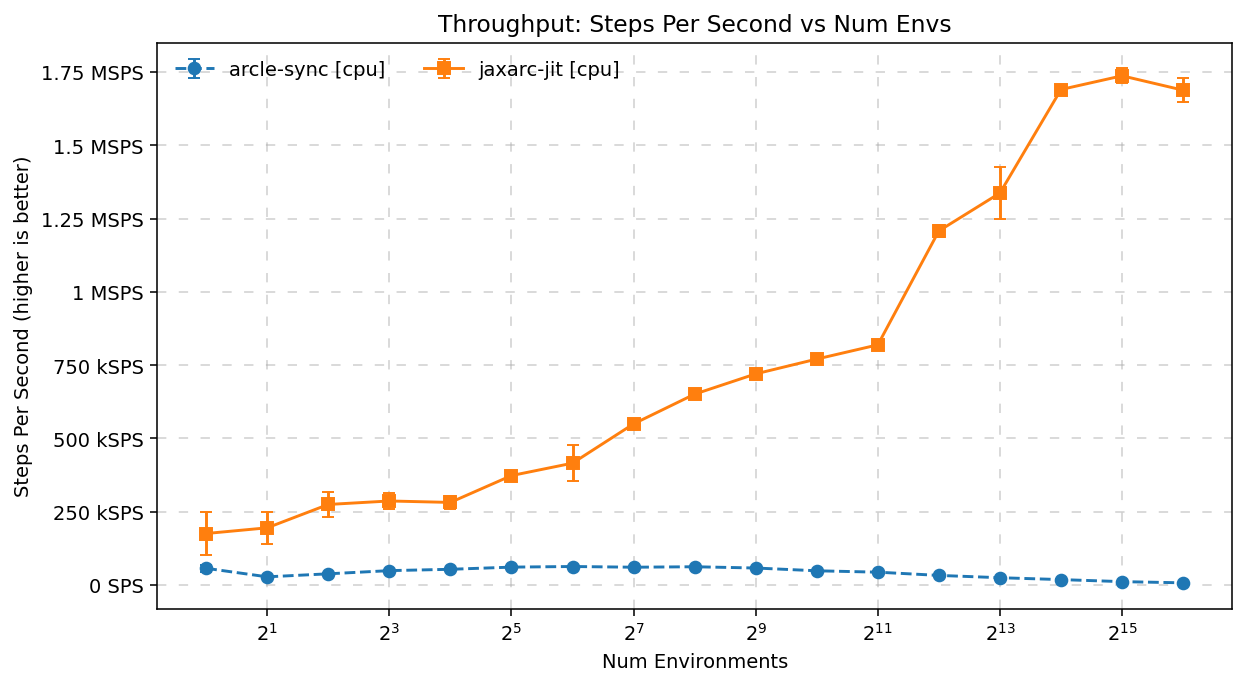

In [20]:
# Plot SPS vs num_envs for filtered data with clearer y-axis
if not filtered_summary:
    print('No data after filters. Adjust run_tag_contains or modes_filter.')
else:
    # Organize by (mode, run_tag)
    by_group: dict[tuple, list[dict[str, Any]]] = defaultdict(list)
    for row in filtered_summary:
        by_group[(row['mode'], row['run_tag'])].append(row)

    fig, ax = plt.subplots(figsize=(9, 5), dpi=140)
    for (mode, tag), rows in by_group.items():
        rows.sort(key=lambda x: x['num_envs'])
        xs = [r['num_envs'] for r in rows]
        ys = [r['sps_mean'] for r in rows]
        yerr = [r['sps_std'] for r in rows]
        label = f"{mode} [{tag or 'untagged'}]"
        style = '-' if 'jaxarc' in (mode or '') else '--'
        marker = 's' if 'jaxarc' in (mode or '') else 'o'
        ax.errorbar(xs, ys, yerr=yerr, marker=marker, linestyle=style, label=label, capsize=3)

    ax.set_title('Throughput: Steps Per Second vs Num Envs')
    ax.set_xlabel('Num Environments')
    ax.set_ylabel('Steps Per Second (higher is better)')
    ax.set_xscale('log', base=2)

    # Configure y-scale
    if yscale in ('linear', 'log', 'symlog'):
        ax.set_yscale(yscale)

    # Configure y-axis formatting
    if yformat == 'eng':
        ax.yaxis.set_major_formatter(EngFormatter(unit='SPS'))
    elif yformat == 'comma':
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}"))
    elif yformat == 'sci':
        sf = ScalarFormatter(useMathText=True)
        sf.set_powerlimits((-2, 2))
        ax.yaxis.set_major_formatter(sf)

    ax.grid(which='both', axis='both', linestyle=(0, (6, 8)), alpha=0.6)
    ax.legend(loc='best', ncol=2, frameon=False)
    plt.tight_layout()
    plt.show()